#Installs

In [1]:
!pip install smote-variants

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import smote_variants as sv

import tensorflow as tf
from tensorflow.keras import layers

tf.__version__
from tensorflow.keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from tensorflow.keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Concatenate, MaxPooling1D, Conv1D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Flatten, GlobalAvgPool1D, GlobalMaxPool1D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

# Metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

# Data

In [3]:
df = pd.read_csv('/content/delirium_mimic_dataset_missing_imputed_label_encoded_numeric_scaled_30_.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
ovs='MCT'
y = df["Delirium"].values
X=df.drop(["Delirium"], axis=1)
training_columns_names=list(X)
oversampler= sv.MulticlassOversampling(oversampler=ovs,
                                            oversampler_params={'random_state': 5})
X, y= oversampler.sample(X, y)

2022-08-31 14:24:06,628:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
INFO:smote_variants:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-08-31 14:24:06,638:INFO:MulticlassOversampling: Sampling minority class with label: 1.0
INFO:smote_variants:MulticlassOversampling: Sampling minority class with label: 1.0
2022-08-31 14:24:06,658:INFO:MCT: Running sampling via ('MCT', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 1, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 5, 'class_name': 'MCT'}")
INFO:smote_variants:MCT: Running sampling via ('MCT', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 1, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 5, 'class_name': 'MCT'}")
2022-08

Oversampled Dataframe

In [5]:
df=pd.DataFrame(X,columns=training_columns_names)
df['Delirium']=y

In [6]:
def rename_columns(df):
  cols=list(df)
  cols_tr=[]
  cols=list(df)
  for col in cols:
      col=col.replace(" ","_")
      col=col.replace("'","_")
      col=col.replace("-","_")
      col=col.replace("*","_")
      col=col.replace("**","_")
      col=col.replace("/","_")
      col=col.replace("(","_")
      col=col.replace(")","_")
      col=col.replace(".","_")
      col=col.lower()
      cols_tr.append(col)
  renaming={}
  i=0
  for col in list(df):
      renaming.update({col:cols_tr[i]})
      i+=1
  return df.rename(renaming,axis=1)
  

In [7]:
df=rename_columns(df)

In [8]:
list(df)

['admission_location',
 'admission_type',
 'age',
 'art_bp_systolic',
 'admission_weight__kg_',
 'anion_gap',
 'bun',
 'calcium_non_ionized',
 'discharge_location',
 'ethnicity',
 'gender',
 'hco3__serum_',
 'heart_rate',
 'insurance',
 'language',
 'los',
 'marital_status',
 'magnesium',
 'non_invasive_blood_pressure_mean',
 'o2_saturation_pulseoxymetry',
 'potassium__whole_blood_',
 'religion',
 'respiratory_rate',
 'sodium__serum_',
 'temperature_celsius',
 'wbc',
 'delirium']

#Helper Functions

In [9]:
def find_cat_features(dataframe,label,flag=0):
  cols=list(dataframe)
  if flag:
    cols.remove(label)
  categorical_features=[]
  i=0
  for col in cols:
      if len(np.unique(dataframe[col].tolist()))<=100:
          categorical_features.append(col)
          i=i+1
  return categorical_features
  
def find_numeric_features(dataframe,label,categorical_variables,flag=0):
  cols=list(dataframe)
  if flag:
    cols.remove(label)
  num_feat=[]
  for col in cols:
    if col not in categorical_variables:
      num_feat.append(col)
  return num_feat

In [10]:
# Define a function to create our tensors
def dataframe_to_dataset(dataframe, label, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop(label)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    df = ds.prefetch(batch_size)
    return ds
    

In [11]:
# Define numerical preprocessing function
def get_normalization_layer(name, dataset):
    
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization(axis=None)

    # Prepare a dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    return normalizer

In [12]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [13]:
def mAP(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)

In [14]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

class Mish(Activation):
    '''
    Mish Activation Function.
    see: https://github.com/digantamisra98/Mish/blob/master/Mish/TFKeras/mish.py
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'

def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'mish': Mish(mish)})
get_custom_objects().update({'custom_gelu': Activation(gelu)})
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})
get_custom_objects().update({'gelu': Activation(gelu)})

#Model

In [15]:
def model(df,label,batch_size=5,epochs=300):
  y_label=label
  # Make a dictionary with int64 columns as keys and np.int32 as values
  int_32 = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int32)
  # Change all columns from dictionary
  df = df.astype(int_32)

  float_32 = dict.fromkeys(df.select_dtypes(np.float64).columns, np.float32)
  df = df.astype(float_32)

  cat_convert = find_cat_features(df,label,flag=1)
  numeric_variables=find_numeric_features(df,label,cat_convert)
  # convert variables
  for i in cat_convert:
      df[i] = df[i].astype("category")

    # Make list of all numerical data (except label)
  list_num = df.drop(columns=[y_label]).select_dtypes(include=[np.number]).columns.tolist()

  # Make list of all categorical data which is stored as integers (except label)
  list_cat_int = df.drop(columns=[y_label]).select_dtypes(include=['category']).columns.tolist()

  # Make list of all categorical data which is stored as string (except label)
  #list_cat_string = df.drop(columns=[y_label]).select_dtypes(include=['string']).columns.tolist()

  print(list_num)
  print(list_cat_int)
  # Make validation data
  df_val = df.sample(frac=0.2, random_state=1337)

  # Make test data
  df_test = df.sample(frac=0.1, random_state=1337)

  # Create training data
  df_train = df.drop(df_val.index)
  df_train = df.drop(df_test.index)

  print(
    "%d training samples and %d validation samples and %d testing samples"
    % (len(df_train), len(df_val),len(df_test)), 
  )

  ytr=df_train[label].values

  train_ds = dataframe_to_dataset(df_train,label, batch_size=batch_size)

  ds_train = dataframe_to_dataset(df_train,label, shuffle=True, batch_size=batch_size*16)
  ds_val = dataframe_to_dataset(df_val,label, shuffle=True, batch_size=batch_size*16)
  ds_test = dataframe_to_dataset(df_test,label, shuffle=True, batch_size=batch_size*16)

  all_inputs = []
  encoded_features = []

  # Numerical features.
  for feature in list_num:
    numeric_col = tf.keras.Input(shape=(1,), name=feature)
    normalization_layer = get_normalization_layer(feature, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

  for feature in list_cat_int:
    categorical_col = tf.keras.Input(shape=(1,), name=feature, dtype='int32')
    encoding_layer = get_category_encoding_layer(name=feature,
                                                dataset=train_ds,
                                                dtype=tf.int32,
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


  #for feature in list_cat_string:
  #  categorical_col = tf.keras.Input(shape=(1,), name=feature, dtype='string')
  #  encoding_layer = get_category_encoding_layer(name=feature,
  #                                              dataset=train_ds,
  #                                              dtype='string',
  #                                              max_tokens=5)
  #  encoded_categorical_col = encoding_layer(categorical_col)
  #  all_inputs.append(categorical_col)
  #  encoded_features.append(encoded_categorical_col)

  measure_to_monitor = 'val_auc' 
  modality = 'max'

  early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                                mode=modality, 
                                patience=3, 
                                verbose=0)

  model_checkpoint = ModelCheckpoint('best.model', 
                                    monitor=measure_to_monitor, 
                                    mode=modality, 
                                    save_best_only=True, 
                                    verbose=0)
  all_features = layers.concatenate(encoded_features)
  
  # First layer
  x = layers.Dense(512, activation="relu")(all_features)
  # Dropout to prevent overvitting
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  # Output layer
  output = layers.Dense(1, activation="sigmoid")(x)

  # Group all layers 
  model = tf.keras.Model(all_inputs, output)
  
  model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss ="binary_crossentropy", 
                metrics=["accuracy",AUC(name='auc'), mAP])
  
  model.fit(ds_train, epochs=epochs, validation_data=ds_val,callbacks=[model_checkpoint, early_stopping],
                        class_weight={0:1.0, 1:(np.sum(ytr==0) / np.sum(ytr==1))},verbose=1)
  
  print('\n')
  print('\n')
  print('Evaluation on validation set: ')
  
  loss,accuracy,auc,map = model.evaluate(ds_val)

  print("Loss", loss)
  print("Accuracy", accuracy)
  print("AUC", auc)
  print("mAP", map)


  print('\n')
  print('\n')
  print('Evaluation on testing set: ')
  loss,accuracy,auc,map = model.evaluate(ds_test)

  print("Loss", loss)
  print("Accuracy", accuracy)
  print("AUC", auc)
  print("mAP", map)


  return model

In [16]:
model=model(df,'delirium',batch_size=32,epochs=300)

['age', 'art_bp_systolic', 'admission_weight__kg_', 'anion_gap', 'bun', 'calcium_non_ionized', 'hco3__serum_', 'heart_rate', 'los', 'magnesium', 'non_invasive_blood_pressure_mean', 'o2_saturation_pulseoxymetry', 'potassium__whole_blood_', 'respiratory_rate', 'sodium__serum_', 'temperature_celsius', 'wbc']
['admission_location', 'admission_type', 'discharge_location', 'ethnicity', 'gender', 'insurance', 'language', 'marital_status', 'religion']
13871 training samples and 3082 validation samples and 1541 testing samples


/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


Epoch 1/300
28/28 [==============================] - 14s 409ms/step - loss: 0.6851 - accuracy: 0.5597 - auc: 0.5827 - mAP: 0.5714 - val_loss: 0.6690 - val_accuracy: 0.6298 - val_auc: 0.6710 - val_mAP: 0.6445
Epoch 2/300
28/28 [==============================] - 8s 303ms/step - loss: 0.6623 - accuracy: 0.6265 - auc: 0.6713 - mAP: 0.6529 - val_loss: 0.6487 - val_accuracy: 0.6467 - val_auc: 0.6970 - val_mAP: 0.7173
Epoch 3/300
28/28 [==============================] - 9s 325ms/step - loss: 0.6428 - accuracy: 0.6433 - auc: 0.6948 - mAP: 0.6839 - val_loss: 0.6309 - val_accuracy: 0.6535 - val_auc: 0.7124 - val_mAP: 0.6828
Epoch 4/300
28/28 [==============================] - 9s 326ms/step - loss: 0.6269 - accuracy: 0.6501 - auc: 0.7135 - mAP: 0.7080 - val_loss: 0.6164 - val_accuracy: 0.6626 - val_auc: 0.7288 - val_mAP: 0.7419
Epoch 5/300
28/28 [==============================] - 11s 397ms/step - loss: 0.6115 - accuracy: 0.6669 - auc: 0.7318 - mAP: 0.7272 - val_loss: 0.6031 - val_accuracy: 0.6720

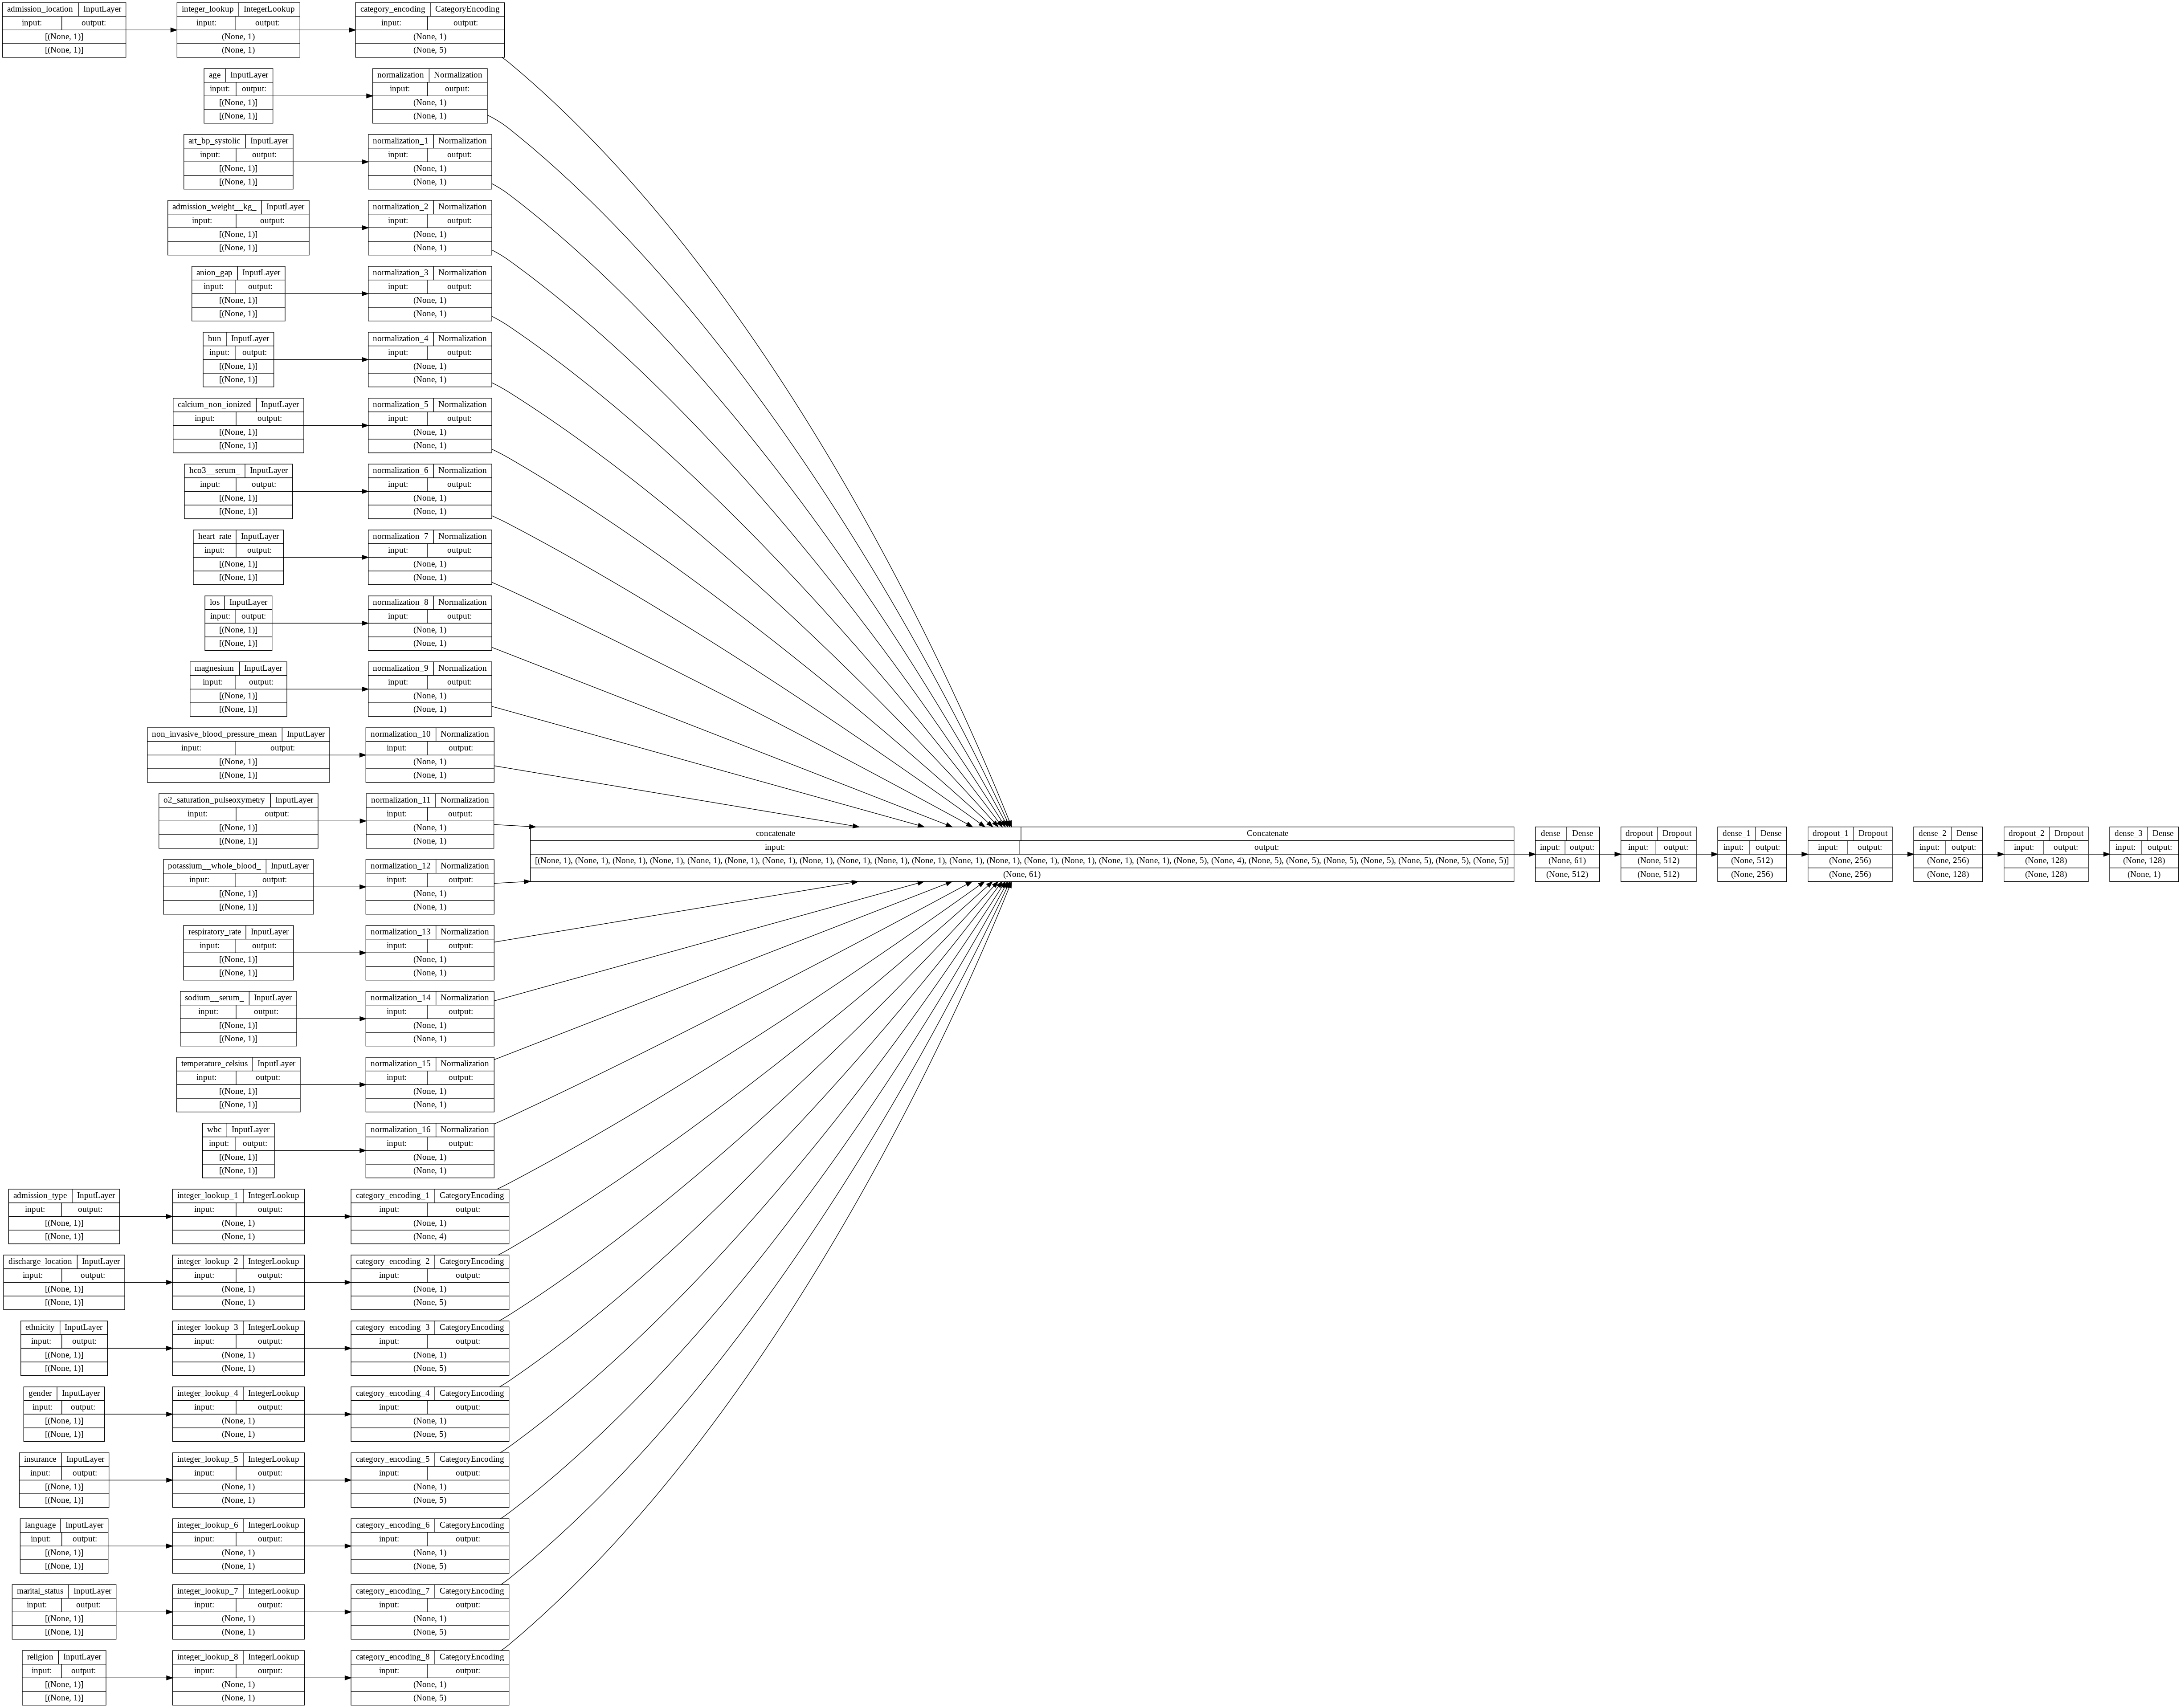

In [17]:
# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")